In [1]:
import pandas as pd
import numpy as np
import random
import fasttext
import certifi
import ssl
import urllib.request
import os
import gzip
import spacy
import shutil
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, confusion_matrix, classification_report
import subprocess
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score,balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV

In [19]:
data = pd.read_excel('/Users/rachael/Downloads/train_df_labelled.xlsx')
#the data verified by the third person will be used as the train set finally
file =  data[['content','sentiment']]
file['sentiment'].value_counts()
label_sentiment= file['sentiment'].value_counts()
label_proportions_sentiment= file['sentiment'].value_counts(normalize=True)
print("Counts of each label_sentiment:")
print(label_sentiment)
print("\nProportions of each label_sentiment:")
print(label_proportions_sentiment)

Counts of each label_sentiment:
sentiment
Negative    262
Neither      98
Positive     48
Name: count, dtype: int64

Proportions of each label_sentiment:
sentiment
Negative    0.642157
Neither     0.240196
Positive    0.117647
Name: proportion, dtype: float64


In [3]:
import re
def remove_urls(text):
    # the expression of URL_pattern
    url_pattern = r'https?://\S+|www\.\S+'
    # use re.sub()to sustitude URL with blank str
    no_url_text = re.sub(url_pattern, '', text)
    return no_url_text

def clean_text(text):
    # Remove anything that is not a letter or space
    clean_text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Optional: Convert text to lower case
    clean_text = clean_text.lower()
    return clean_text

In [4]:
#clean the data
file['content'] = file['content'].apply(remove_urls) 
file['content'] = file['content'].apply(clean_text) 

#convert categorical to numerical 
file['sentiment'] = file['sentiment'].replace({'Positive':0,'Negative': 1, 'Neither': 2})

# Load dataset
y = file['sentiment']
X = file['content']

/var/folders/vq/5p2k6x290wzfc5dzz5xm78bm0000gp/T/ipykernel_19416/280474677.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file['content'] = file['content'].apply(remove_urls)
/var/folders/vq/5p2k6x290wzfc5dzz5xm78bm0000gp/T/ipykernel_19416/280474677.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file['content'] = file['content'].apply(clean_text)
/var/folders/vq/5p2k6x290wzfc5dzz5xm78bm0000gp/T/ipykernel_19416/280474677.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [5]:
import fasttext

# Path to your FastText pre-trained word embedding file
fasttext_model_path = '/Users/rachael/Downloads/cc.nl.300.bin'

# Load the FastText model
ft = fasttext.load_model(fasttext_model_path)

In [6]:
nlp = spacy.load("nl_core_news_sm")
#tokenize
def tokenize(text):
    doc = nlp(text)
    return [token.text for token in doc]

def sentence_to_avg_vec(tokens, model):
    vector_size = model.get_dimension()
    vec = np.zeros(vector_size)
    count = 0
    for token in tokens:
        vec += model.get_word_vector(token)
        count += 1
    if count != 0:
        vec /= count
    return vec

In [7]:
param_dist= {
    'n_estimators': range(10, 101),
    'criterion': ['gini', 'entropy'],
    'max_depth': range(2, 51),
    'min_samples_split': range(2, 11),
    'min_samples_leaf': range(1, 11),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

test_scores = []
best_params_list = []

# Stratified K-fold for maintaining label distribution,shuffle=True确保每次迭代的数据划分不同
# Initialize parameters
best_score = 0
best_params = {}
f1_scores = []

In [9]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in skf.split(X, y):
    trainX, testX = X.iloc[train_index], X.iloc[test_index]
    trainy, testy = y.iloc[train_index], y.iloc[test_index]
    
    X_train_tokenized = trainX.apply(tokenize)
    train_vectors = np.array([sentence_to_avg_vec(sentence,ft) for sentence in X_train_tokenized])

    X_test_tokenized = testX.apply(tokenize)
    test_vectors = np.array([sentence_to_avg_vec(sentence,ft) for sentence in X_test_tokenized])
    #feature extraction for test data

    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    rf = RandomForestClassifier(random_state=42,class_weight='balanced')
    randomized_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_dist,
        n_iter=100,  # Number of parameter settings that are sampled
        scoring='f1_macro',
        n_jobs=-1,  # Use all available cores
        cv=inner_cv,
        random_state=42
    )

    # Fit Randomized Search
    randomized_search.fit(train_vectors,trainy)

    # Get the best model from Randomized Search
    best_model = randomized_search.best_estimator_
    best_params = randomized_search.best_params_
    best_score = randomized_search.best_score_

    # Evaluate on the test set
    test_predictions = best_model.predict(test_vectors)
    test_score =f1_score(testy, test_predictions,average='macro')
    
    test_scores.append(test_score)
    best_params_list.append(best_params)

    print(f"Fold test score: {test_score}")
    print(f"Best parameters: {best_params}")

# Summarize the results
mean_test_score = np.mean(test_scores)
std_test_score = np.std(test_scores)

print(f"Mean test score: {mean_test_score}")
print(f"Standard deviation of test scores: {std_test_score}")
print("Best parameters for each fold:")
for i, params in enumerate(best_params_list):
    print(f"Fold {i + 1}: {params}")

Fold test score: 0.3173333333333333
Best parameters: {'n_estimators': 13, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 37, 'criterion': 'entropy', 'bootstrap': False}
Fold test score: 0.3448975188781014
Best parameters: {'n_estimators': 74, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 47, 'criterion': 'gini', 'bootstrap': False}
Fold test score: 0.341025641025641
Best parameters: {'n_estimators': 46, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 3, 'criterion': 'entropy', 'bootstrap': True}
Fold test score: 0.4333333333333333
Best parameters: {'n_estimators': 16, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'max_depth': 46, 'criterion': 'gini', 'bootstrap': False}
Fold test score: 0.3289593584836887
Best parameters: {'n_estimators': 12, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 36, 'criterion': 'entropy',

In [10]:
from collections import Counter
best_params_counter = Counter(tuple(sorted(params.items())) for params in best_params_list)
most_common_params = dict(best_params_counter.most_common(1)[0][0])

print("Most common best parameters:", most_common_params)

Most common best parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 37, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 13}


In [7]:
most_common_params = {'n_estimators': 16, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'max_depth': 46, 'criterion': 'gini', 'bootstrap': False}


In [8]:
X_sentences = [item for item in list(X)]
X_tokenized = X.apply(tokenize)
X_embeddings = np.array([sentence_to_avg_vec(sentence,ft) for sentence in X_tokenized])

final_model = RandomForestClassifier(random_state=42,**most_common_params,class_weight='balanced')
final_model.fit(X_embeddings, y)

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=46,
                       min_samples_leaf=8, n_estimators=16, random_state=42)

In [9]:
test = pd.read_excel('/Users/rachael/Downloads/test_df_labelled.xlsx')
#the data verified by the third person will be used as the train set finally
test = test[['content','sentiment']]
test['content'] = test['content'].apply(remove_urls) 
test['content'] = test['content'].apply(clean_text) 
test['sentiment'] = test['sentiment'].replace({'Positive':0,'Negative': 1, 'Neither': 2})
test_tokenized = test['content'].apply(tokenize)
test_embedding = np.array([sentence_to_avg_vec(sentence,ft) for sentence in test_tokenized])
test_predictions = final_model.predict(test_embedding)
test_score = accuracy_score(test['sentiment'], test_predictions)
conf_matrix = confusion_matrix(test['sentiment'], test_predictions)
class_report = classification_report(test['sentiment'], test_predictions)
print(class_report)

              precision    recall  f1-score   support

           0       0.21      0.13      0.16        38
           1       0.66      0.82      0.73       245
           2       0.59      0.39      0.47       124

    accuracy                           0.62       407
   macro avg       0.49      0.45      0.45       407
weighted avg       0.60      0.62      0.60       407



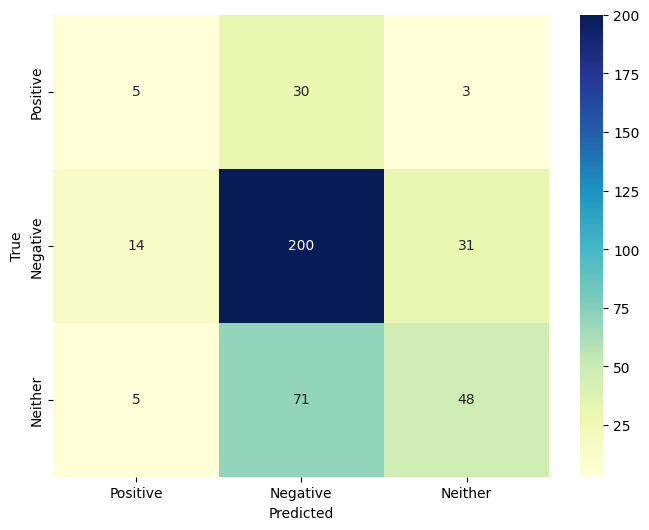

ValueError: DataFrame constructor not properly called!

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
# 绘制混淆矩阵热图
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", xticklabels=['Positive', 'Negative', 'Neither'], yticklabels=['Positive', 'Negative', 'Neither'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 绘制分类报告热图
report_df = pd.DataFrame(class_report).transpose()

plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap="YlGnBu")
plt.title('Classification Report Heatmap')
plt.show()

In [18]:
report_df = pd.DataFrame(class_report).transpose()


ValueError: DataFrame constructor not properly called!

In [10]:
data = pd.read_excel('/Users/rachael/Downloads/test_df_labelled.xlsx')
#the data verified by the third person will be used as the train set finally
file =  data[['content','stance','sentiment']]
file['stance'] = file['stance'].replace({'Support':0,'Aganist': 1, 'Neither': 2})
file['sentiment'] = file['sentiment'].replace({'Positive':0,'Negative': 1, 'Neither': 2})
file['content'] = file['content'].apply(remove_urls) 
file['content'] = file['content'].apply(clean_text) 
stance_0_sentiment = file[file['stance'] == 0][['content','sentiment']]
stance_1_sentiment = file[file['stance'] == 1][['content','sentiment']]
stance_2_sentiment = file[file['stance'] == 2][['content','sentiment']] 

/var/folders/vq/5p2k6x290wzfc5dzz5xm78bm0000gp/T/ipykernel_19416/2001043649.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file['stance'] = file['stance'].replace({'Support':0,'Aganist': 1, 'Neither': 2})
/var/folders/vq/5p2k6x290wzfc5dzz5xm78bm0000gp/T/ipykernel_19416/2001043649.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file['sentiment'] = file['sentiment'].replace({'Positive':0,'Negative': 1, 'Neither': 2})
/var/folders/vq/5p2k6x290wzfc5dzz5xm78bm0000gp/T/ipykernel_19416/2001043649.py:6: Se

In [11]:
stance_0_tokenized = stance_0_sentiment['content'].apply(tokenize)
stance_0_embedding = np.array([sentence_to_avg_vec(sentence,ft) for sentence in stance_0_tokenized])
stance_0_predictions = final_model.predict(stance_0_embedding )
stance_0_class_report = classification_report(stance_0_sentiment['sentiment'], stance_0_predictions)
print('stance_0_class_report:',stance_0_class_report)

stance_0_class_report:               precision    recall  f1-score   support

           0       0.43      0.12      0.19        25
           1       0.52      0.76      0.62        38
           2       0.46      0.46      0.46        13

    accuracy                           0.50        76
   macro avg       0.47      0.45      0.42        76
weighted avg       0.48      0.50      0.45        76



In [12]:
stance_1_tokenized = stance_1_sentiment['content'].apply(tokenize)
stance_1_embedding = np.array([sentence_to_avg_vec(sentence,ft) for sentence in stance_1_tokenized])
stance_1_predictions = final_model.predict(stance_1_embedding )
stance_1_class_report = classification_report(stance_1_sentiment['sentiment'], stance_1_predictions)
print('stance_0_class_report:',stance_1_class_report)

stance_0_class_report:               precision    recall  f1-score   support

           0       0.18      0.40      0.25         5
           1       0.90      0.83      0.87       170
           2       0.17      0.25      0.20        16

    accuracy                           0.77       191
   macro avg       0.42      0.49      0.44       191
weighted avg       0.82      0.77      0.79       191



In [15]:
stance_2_tokenized = stance_2_sentiment['content'].apply(tokenize)
stance_2_embedding = np.array([sentence_to_avg_vec(sentence,ft) for sentence in stance_2_tokenized])
stance_2_predictions = final_model.predict(stance_2_embedding)
stance_2_class_report = classification_report(stance_2_sentiment['sentiment'], stance_2_predictions)
print('stance_0_class_report:',stance_2_class_report)

stance_0_class_report:               precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.34      0.81      0.48        37
           2       0.84      0.40      0.54        95

    accuracy                           0.49       140
   macro avg       0.39      0.40      0.34       140
weighted avg       0.66      0.49      0.49       140

